In [1]:
import warnings

from functools import partial
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

from statsmodels.tsa.stattools import acf

from neurodsp.sim import sim_poisson_pop, sim_synaptic_kernel
from neurodsp.spectral import compute_spectrum

from timescales.sim import sim_poisson_distribution, sim_spikes_synaptic
from timescales.est import fit_acf, exp_decay_func

In [2]:
# Settings
np.random.seed(0)
n_seconds = 10
fs = 1000
mu = 50
tau_target = .02
   
# Randomly sample isi's
times = np.arange(0, n_seconds, 1/fs)
isi = np.round_(np.random.exponential(scale=mu, size=len(times))).astype(int)
isi = isi[np.where(isi > 0)[0]]

last_ind = np.where(isi.cumsum() >= len(times))[0][0]
isi = isi[:last_ind]

# Randomly sample tau dist
taus = np.random.normal(loc=tau_target * fs, scale=3, size=len(isi))
taus = np.sort(taus)

# Convert taus to kernels
times_kernel = np.arange(100)
kernels = np.zeros((len(taus), 100))

for ind, tau in enumerate(taus):
    kernels[ind] += np.exp(-times_kernel/taus[ind])

# Get probabilities
probs_multi  = sim_poisson_distribution(n_seconds, fs, kernels, isi=isi)

# Fit
corrs_multi, params_multi = fit_acf(probs_multi, 1000)

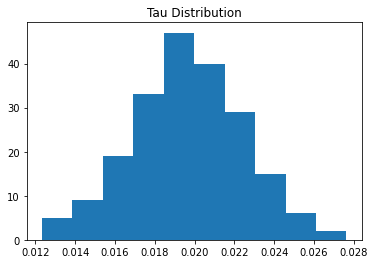

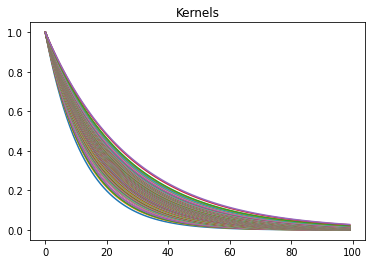

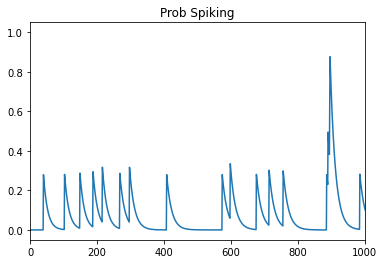

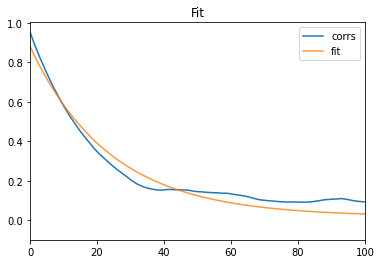

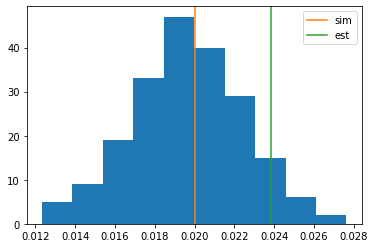

In [3]:
plt.figure(0)
plt.title('Tau Distribution')
plt.hist(taus / fs)


plt.figure(1)
plt.title('Kernels')
for k in kernels:
    plt.plot(k)

plt.figure(2)
plt.title('Prob Spiking')
plt.plot(probs_multi)
plt.xlim(0, 1000)

plt.figure(3)
plt.title('Fit')
plt.plot(corrs_multi, label='corrs')
plt.plot(exp_decay_func(np.arange(0, 1001), *params_multi)[1:], alpha=.8, label='fit')
plt.legend()
plt.xlim(0, 100)


plt.figure(4)
plt.hist(taus / fs);
plt.axvline(tau_target, color='C1', label='sim')
plt.axvline(params_multi[1] / fs, color='C2', label='est')
plt.legend();

In [4]:
from neurodsp.spectral import compute_spectrum
from timescales.est.psd import convert_knee_val
from fooof import FOOOF

def fit_psd(spikes, fs, f_range, fooof_init=None, n_jobs=-1):
    
    freqs, powers = compute_spectrum(spikes, fs, f_range=f_range)
    
    if fooof_init is not None:
        fm = FOOOF(aperiodic_mode='knee', verbose=False, **fooof_init)
    else:
        fm = FOOOF(aperiodic_mode='knee', verbose=False)
        
    fm.fit(freqs, powers, f_range)
    
    knee = fm.get_params('aperiodic', 'knee')
    exp = fm.get_params('aperiodic', 'exponent')
    
    knee_freq, knee_tau = convert_knee_val(knee, exponent=exp)
    
    return knee_freq, knee_tau

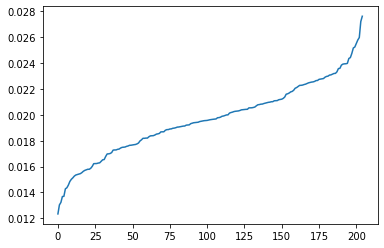

In [5]:
plt.plot(taus/fs)

/home/rph/Projects/timescale-methods/.env/lib/python3.8/site-packages/fooof/core/funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


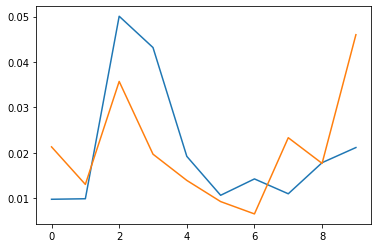

In [6]:
# Fit
n_divs = 10

p_reshape = probs_multi.reshape(n_divs, -1)

corrs_tr = np.zeros((n_divs, 200))
params_tr = np.zeros((n_divs, 3))

for ind, p in enumerate(p_reshape):
    c_tr, p_tr = fit_acf(p, 200)
    params_tr[ind] = p_tr
    
plt.plot(params_tr[:, 1]/fs)


# Fit
taus_tr = np.zeros(n_divs)

for ind, p in enumerate(p_reshape):
    _, tau_fit = fit_psd(p, fs, (1, 100), fooof_init={'max_n_peaks': 0})
    taus_tr[ind] = tau_fit
    
plt.plot(taus_tr);

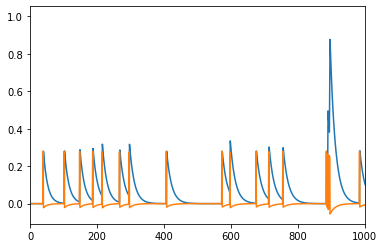

In [7]:
plt.plot(probs_multi)
plt.plot(np.diff(probs_multi))
plt.xlim(0, 1000);

In [114]:
from scipy.optimize import curve_fit

def test(xs, *params):
    
    params = np.array(params)
    params = params.reshape(3, -1)
    
    _maxima = params[0].astype(int)
    _taus = params[1]
    _heights = params[2]
    

    arr = np.zeros(len(xs))

    for m, t, h in zip(_maxima, _taus, _heights):

        end = m+100 if m+100 < len(arr) else m+(len(arr)-m)

        times = np.arange(100)
        
        xs = np.zeros(m+end+100)
        xs[0] = 1
        
        arr[m:end] += np.convolve(times, np.exp(-times/(t * fs))[:end-m] * h)[:m+end]
        
    return arr

In [115]:
n_iters = 5

maxima = np.where(np.diff(probs_multi) >= .1)[0] + 1
params = []

for i in np.arange(0, len(maxima), n_iters):
    
    _maxima = maxima.copy()[i:i+5]
    
    if i+n_iters+1 >= len(maxima):
        end = len(maxima) - 1
    else:
        end = i+n_iters+1
        
    _probs_multi = probs_multi[_maxima[0]:maxima[end]]

    if _maxima[0] == 0:
        _last_ht = np.append(0, probs_multi[_maxima[1:]])
    else:
        _last_ht = probs_multi[_maxima-1]
                                    
    _heights = probs_multi[_maxima] - _last_ht
    
    _taus = np.array([.02] * len(_heights))

    n = len(_maxima)

    _maxima -= _maxima.min()
    
    bounds = [(*(_maxima - 5), *[0.000001] * n, *[.001] * n), 
              (*(_maxima + 5), *[1]     * n, *[1] * n)]

    _params, _ = curve_fit(test, np.arange(len(_probs_multi)), _probs_multi, 
                           p0=np.concatenate((_maxima, _taus, _heights)), bounds=bounds, maxfev=10000)
    params.append(_params)

ValueError: operands could not be broadcast together with shapes (100,) (199,) (100,) 

In [112]:
[p.reshape(3, -1)[1] for p in params]

[array([0.01234071, 0.01302661, 0.01329745, 0.01508417, 0.09716749]),
 array([0.01425324, 0.01435089, 0.01456894, 0.01384678, 0.02011876]),
 array([0.0151041 , 0.01526843, 0.01534911, 0.99991848, 0.99999037]),
 array([0.01659488, 0.01659675, 0.01948664, 0.0194038 , 0.01938848]),
 array([0.01579322, 0.01577084, 0.01595501, 0.00954804, 0.03794928]),
 array([0.01622254, 0.01618048, 0.01637897, 0.01799253, 0.03556388]),
 array([0.01643838, 0.01674173, 0.01620184, 0.00863562, 0.07884374]),
 array([0.01695574, 0.01700282, 0.0172826 , 0.01737014, 0.089736  ]),
 array([0.01728295, 0.01731628, 0.01823875, 0.0170675 , 0.06131562]),
 array([0.01773815, 0.02351344, 0.01398944, 0.01678448, 0.18410725]),
 array([0.01748977, 0.01759735, 0.0248431 , 0.0251561 , 0.02919735]),
 array([0.01788265, 0.01807047, 0.01778354, 0.02492549, 1.        ]),
 array([0.01595286, 0.02073297, 0.03779551, 0.03523085, 0.03272253]),
 array([0.01832611, 0.01852061, 0.01857528, 0.01856486, 0.01868567]),
 array([0.0186858 , 

In [116]:
i = 15

_maxima = maxima.copy()[i:i+5]
    
if i+n_iters+1 >= len(maxima):
    end = len(maxima) - 1
else:
    end = i+n_iters+1

_probs_multi = probs_multi[_maxima[0]:maxima[end]]

if _maxima[0] == 0:
    _last_ht = np.append(0, probs_multi[_maxima[1:]])
else:
    _last_ht = probs_multi[_maxima-1]

_heights = probs_multi[_maxima] - _last_ht

_taus = np.array([.02] * len(_heights))

n = len(_maxima)

_maxima -= _maxima.min()

bounds = [(*(_maxima - 5), *[0.000001] * n, *[.001] * n), 
          (*(_maxima + 5), *[1]     * n, *[1] * n)]

_params, _ = curve_fit(test, np.arange(len(_probs_multi)), _probs_multi, 
                       p0=np.concatenate((_maxima, _taus, _heights)), bounds=bounds, maxfev=10000)
params.append(_params)

ValueError: operands could not be broadcast together with shapes (100,) (102,) (100,) 

In [103]:
_maxima = maxima.copy()[i:i+5]

_probs_multi = probs_multi[_maxima[0]:maxima[end]]

In [104]:
maxima

array([  40,  103,  149,  188,  216,  268,  297,  408,  574,  598,  676,
        714,  756,  886,  890,  895,  896,  985, 1060, 1162, 1354, 1434,
       1465, 1541, 1547, 1598, 1606, 1751, 1788, 1815, 1830, 1904, 1934,
       1976, 1977, 2025, 2072, 2120, 2264, 2321, 2343, 2372, 2432, 2435,
       2490, 2546, 2558, 2565, 2584, 2607, 2649, 2678, 2901, 2906, 2918,
       2927, 2980, 2995, 3026, 3040, 3049, 3055, 3108, 3115, 3126, 3149,
       3235, 3240, 3331, 3336, 3523, 3555, 3743, 3789, 3856, 3858, 3875,
       3881, 3899, 3905, 3924, 3951, 3954, 4013, 4055, 4070, 4107, 4112,
       4155, 4287, 4306, 4361, 4368, 4431, 4448, 4458, 4502, 4503, 4591,
       4648, 4664, 4730, 4894, 4908, 4951, 4996, 5038, 5051, 5204, 5234,
       5328, 5388, 5406, 5490, 5515, 5621, 5665, 5772, 5831, 5896, 5931,
       6087, 6139, 6167, 6214, 6215, 6233, 6287, 6304, 6352, 6380, 6387,
       6405, 6447, 6492, 6535, 6588, 6641, 6669, 6782, 6805, 6834, 6945,
       7027, 7088, 7093, 7219, 7282, 7620, 7628, 77

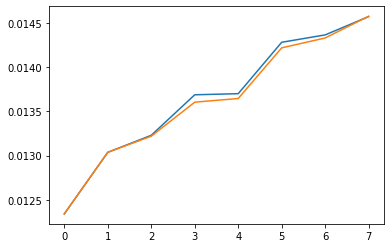

In [20]:
plt.plot(taus[:8]/fs)
plt.plot(taus_hats)

In [17]:
# Settings
np.random.seed(0)

# Convert tau to kernels
times_kernel = np.arange(100)
kernel = np.exp(-times_kernel/(tau_target * fs))

# Get probabilities
probs  = sim_poisson_distribution(n_seconds, fs, kernel, isi=isi)

# Fit
corrs, params = fit_acf(probs, 1000)

sim tau   :  0.02
tau single:  0.023088339495861986
tau multi :  0.023387187448249757


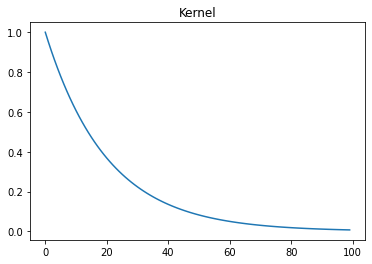

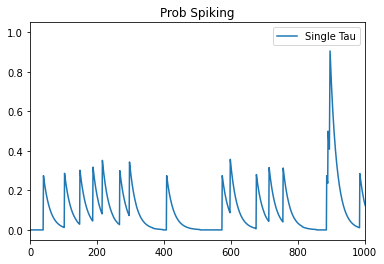

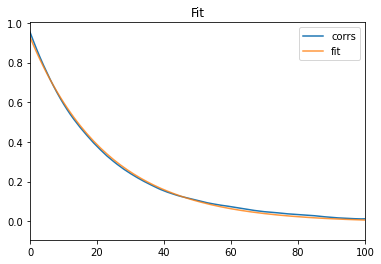

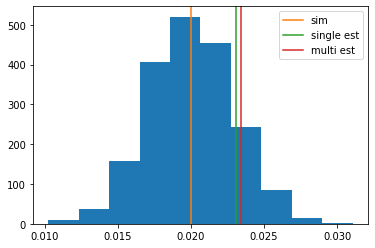

In [21]:
plt.figure(0)
plt.title('Kernel')
plt.plot(kernel)

plt.figure(1)
plt.title('Prob Spiking')
plt.plot(probs, label='Single Tau')
plt.xlim(0, 1000)
plt.legend()

plt.figure(3)
plt.title('Fit')
plt.plot(corrs, label='corrs')
plt.plot(exp_decay_func(np.arange(1, 1001), *params), alpha=.8, label='fit')
plt.legend()
plt.xlim(0, 100)

plt.figure(4)
plt.hist(taus / fs);
plt.axvline(tau_target, color='C1', label='sim')
plt.axvline(params[1] / fs, color='C2', label='single est')
plt.axvline(params_multi[1] / fs, color='C3', label='multi est')
plt.legend();

print('sim tau   : ', tau_target)
print('tau single: ', params[1]/fs)
print('tau multi : ', params_multi[1]/fs)

In [50]:
# If not provided, compute t_ker as a function of decay time constant
from neurodsp.utils.data import create_times, compute_nsamples
n_neurons=1
firing_rate= 2
tau_d = .01
tau_r = 0

t_ker = 5. * tau_d

# Simulate an extra bit because the convolution will trim & turn off normalization
sig = sim_poisson_pop((n_seconds + t_ker), fs, n_neurons, firing_rate,
                       mean=None, variance=None)
ker = sim_synaptic_kernel(t_ker, fs, tau_r, tau_d)
sig = np.convolve(sig, ker, 'valid')[:compute_nsamples(n_seconds, fs)]



(0.0, 100.0)

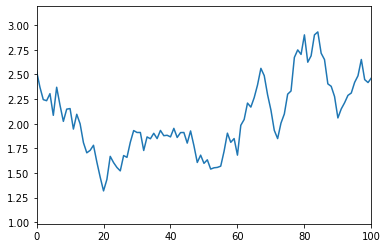

In [51]:
plt.plot(sig)
plt.xlim(0, 100)

(0.0, 100.0)

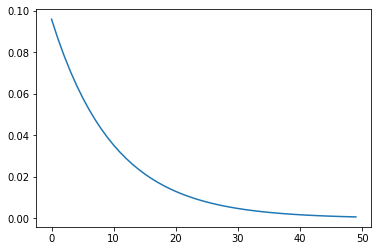

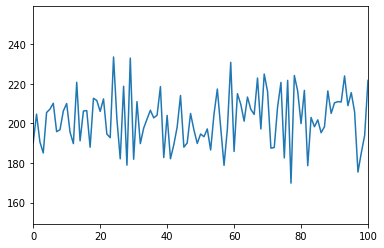

In [49]:
plt.figure(0)
plt.plot(ker)

plt.figure(1)
pos = sim_poisson_pop((n_seconds + t_ker), fs, n_neurons, firing_rate,
                       mean=None, variance=None)

plt.plot(pos)
plt.xlim(0, 100)

In [39]:
corrs, params = fit_acf(sig, 100)

In [40]:
params[1]/fs

0.0019409302984168127